### Imports

In [1]:
# Import analysis libraries
import time
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import log_loss
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder

# from notebooks/ directory
import sys, os

# ADDITIONS:
from src.RAI import DataBiasChecker, ModelBiasRanker, ModelBiasHandler

### Read data

In [2]:
## Download input file from BCG Egnyte - RAI folder
## https://bcg01.egnyte.com/navigate/folder/881ba5c2-8f6e-4eb6-b940-848faa78dee9
model_input_path = './data/usa_IPUMS_2022.csv.gz'
model_input = pd.read_csv(model_input_path, compression='gzip', header=0, sep=',', quotechar='"', error_bad_lines=False)


In [3]:
model_input.YEAR.value_counts()

2019    3239553
2018    3214539
2017    3190040
2016    3156487
2015    3147005
Name: YEAR, dtype: int64

In [4]:
pd.set_option('display.max_columns', None)

model_input.columns

Index(['YEAR', 'SAMPLE', 'SERIAL', 'CBSERIAL', 'NUMPREC', 'SUBSAMP', 'HHWT',
       'HHTYPE', 'CBHHTYPE', 'CLUSTER', 'ADJUST', 'CPI99', 'REGION',
       'STATEICP', 'METRO', 'MET2013', 'METPOP10', 'CITY', 'STRATA', 'GQ',
       'OWNERSHP', 'OWNERSHPD', 'MORTGAGE', 'MORTAMT1', 'MORTAMT2', 'RENT',
       'HHINCOME', 'VALUEH', 'COUPLETYPE', 'SSMC', 'NFAMS', 'NSUBFAM',
       'NCOUPLES', 'NMOTHERS', 'NFATHERS', 'MULTGEN', 'MULTGEND', 'CBNSUBFAM',
       'RESPMODE', 'PERNUM', 'PERWT', 'RELATE', 'RELATED', 'SEX', 'AGE',
       'MARST', 'MARRNO', 'RACE', 'RACED', 'HISPAN', 'HISPAND', 'CITIZEN',
       'YRSUSA1', 'SPEAKENG', 'SCHOOL', 'EDUC', 'EDUCD', 'GRADEATT',
       'GRADEATTD', 'SCHLTYPE', 'INCTOT', 'FTOTINC', 'INCWAGE', 'INCSS',
       'POVERTY', 'OCCSCORE', 'SEI', 'HWSEI'],
      dtype='object')

### Filter down to working age (18-80) records for which we have income

(15947624, 68)
(13285667, 68)


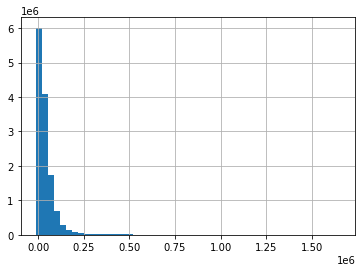

In [5]:
# Remove Missing values
# model_input.INCTOT.max()
# 9999999
print(model_input.shape)
model_input = model_input[model_input['INCTOT'] != 9999999]
print(model_input.shape)
model_input.INCTOT.hist(bins = 50)

(11704918, 69)
(11704918, 69)


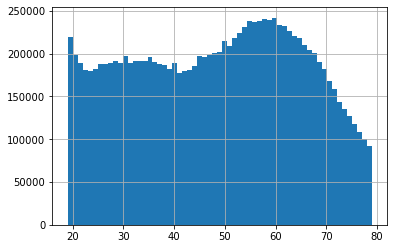

In [104]:
print(model_input.shape)
model_input = model_input[model_input['AGE'] > 18]
model_input = model_input[model_input['AGE'] < 80]
print(model_input.shape)
model_input.AGE.hist(bins = 61)

### Create a binary target variables

In [7]:
model_input['high_income'] = np.where(model_input.INCTOT > 250000,1,0)
model_input['high_income'].value_counts(normalize=True)

0    0.983825
1    0.016175
Name: high_income, dtype: float64

### Quick check if there is gender bias

In [8]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

year_sex = model_input[['YEAR', 'SEX','INCTOT']]
year_sex = year_sex.groupby(['YEAR', 'SEX']).median()
year_sex

INCTOT
YEAR SEX        
2015 1     34000
     2     20000
2016 1     35000
     2     20000
2017 1     35900
     2     21000
2018 1     37000
     2     22000
2019 1     40000
     2     24000

In [9]:
### Variables of interest

# SEX	AGE	MARST	RACE
# SPEAKENG	SCHOOL	EDUC	EDUCD	GRADEATT	GRADEATTD	SCHLTYPE	
# INCTOT	FTOTINC	INCWAGE
# POVERTY
# CBHHTYPE
# RENT MORTGAGE
# VALUEH

### Input parameters

In [10]:
# set parameters for bias check
dependent = 'high_income'  # dependent variable we measure
protected_group = 'SEX'  # protected group for which we compare outcomes
outcome_advantage = 1
pg_disadvantage = 0 ## this is the class we want to test for whether an advantage exists
dependent_bin = 'high_income_target'
thresh_min = .6
thresh_max = 1

# set additional parameters for the toy model [skip if you have your own model]
target_rate = .98  # target_rate = 1 - desired (target) positive rate, i.e., outome rate: percentage of the population that classified as predicted outcome 1.
test_size = .4
random_state = 777
n_estimators = 400
bias_detect_thresh = .2
data_name = 'income_dataset'

### RAI Framework

In [51]:
model_sample = model_input.sample(n=20000)

In [52]:
# Create IDs to number individuals
pg_array = model_sample[protected_group]

# Select dependent and PG -- measure historical bias
# Encode chose parameter for disadvantaged class as binary variable
model_sample[dependent_bin] = model_sample[dependent]

# Encode chose parameter for disadvantaged class as binary variable
# model_sample[protected_group] = model_sample[protected_group]

##### Run functions to create dummies for categorical variables and normalize numeric
num_vars = ['RENT','MORTGAGE', 'AGE']

cat_vars = ['EDUC','MARST','RACE']


In [53]:
model_sample.SEX.value_counts()

2    10182
1     9818
Name: SEX, dtype: int64

In [54]:
def normalize_num(df, num_cols):
    """
    This function normalizes numeric variables

    Args:
        df: pandas df with numeric columns to normalize
        num_cols: list of numeric column names

    Result:
        Returns same dataframe with normalized data
    """

    x = df[num_cols].values  # returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    df_num = pd.DataFrame(x_scaled)
    df_num.columns = num_cols
    df_num = df_num.reset_index(drop=True)

    df_drop = df.drop(num_cols, axis=1)
    df_drop = df_drop.reset_index(drop=True)
    df_final = pd.concat([df_drop, df_num], axis=1)

    return df_final

In [57]:
# This is an internal function which one-hot encodes all categorical and normalizes all numeric variables
model_data_norm = normalize_num(model_sample, num_vars)
model_data_cat = pd.get_dummies(model_sample[cat_vars], columns=cat_vars)
model_data_num = model_data_norm[num_vars]

# temp fix issue with multiple indices, creating more rows
model_data_num.index = model_sample.index
model_data_norm.index = model_sample.index
model_data_cat.index = model_sample.index

# Join
model_data_norm['ID'] = model_data_norm.index
model_data = pd.concat([model_data_norm[[dependent_bin, "ID"]], model_data_cat, model_data_num], axis=1)
# model_data = pd.DataFrame(np.hstack([model_data_norm[[dependent_bin, "ID"]], model_data_cat, model_data_num]))

# Print shape of final machine-learning ready data frame
print("Model data shape: ", model_data.shape)

Model data shape:  (20000, 31)


In [24]:
model_data.columns

Index(['EDUC_0', 'EDUC_1', 'EDUC_2', 'EDUC_3', 'EDUC_4', 'EDUC_5', 'EDUC_6',
       'EDUC_7', 'EDUC_8', 'EDUC_10', 'EDUC_11', 'MARST_1', 'MARST_2',
       'MARST_3', 'MARST_4', 'MARST_5', 'MARST_6', 'RACE_1', 'RACE_2',
       'RACE_3', 'RACE_4', 'RACE_5', 'RACE_6', 'RACE_7', 'RACE_8', 'RACE_9',
       'RENT', 'MORTGAGE', 'AGE'],
      dtype='object')

### 01 - Bias Index Check

In [59]:
bias_checker = DataBiasChecker(pvalue_threshold=0.1, 
                               test_type="z-test",
                               is_2_sided=False)

In [62]:
pg = model_sample[protected_group]
y = model_data[dependent_bin]

bias_checker.fit(pg, y)

In [63]:
bias_checker.biased_

True

In [64]:
bias_checker.p_value_

9.897567998072388e-17

In [88]:
bias_checker.historic_crosstab_

high_income_target,0,1
SEX,,
1,0.976,0.024
2,0.991,0.009


In [89]:
# Historical bias index
bias_checker.historic_crosstab_[1][2]/bias_checker.historic_crosstab_[1][1]
# 0.384

0.38406593223668223

### 03 - Fairness Scenarios

In [66]:
model_data = model_data.fillna(0)

In [68]:
X_train = model_data.drop(labels=[dependent_bin], axis=1)
X_train = X_train.drop(labels=['ID'], axis=1)

y_train = model_data[dependent_bin]
pg_train = model_sample[protected_group]

grid = {"n_estimators": [100, 200, 400],
        "max_depth": [4, 6, 8, 10]}
rf_clf = RandomForestClassifier(class_weight="balanced", random_state=42)
clf_cv = GridSearchCV(rf_clf, grid, cv=5, scoring="roc_auc", refit=True, verbose=3, n_jobs=-1)
clf_cv.fit(X_train, y_train)

best_estimator = clf_cv.best_estimator_
best_params = clf_cv.best_params_
print(best_params)

# best_estimator = RandomForestClassifier(max_depth=10, n_estimators=400, class_weight="balanced", random_state=42)
# best_estimator.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  58 out of  60 | elapsed:   19.1s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   19.2s finished


{'max_depth': 4, 'n_estimators': 400}


In [69]:
bias_ranker = ModelBiasRanker(best_estimator,
                              pos_rate=0.1,
                              bias_tolerance=0.2)

In [70]:
pg_train.value_counts()

2    10182
1     9818
Name: SEX, dtype: int64

In [71]:
bias_ranker.fit(X_train, y_train, pg_train)

In [72]:
bias_ranker.results_

,Bias Test,Bias Index,Accuracy,TP,FN,TN,FP,Non PG Positive Rate,PG Positive Rate
Naive,Pass,0.996,0.794,0.058,0.942,0.995,0.005,0.215,0.214
Threshold Best,Pass,0.931,0.887,0.077,0.922,0.991,0.009,0.118,0.110
Historic Parity,Fail,2.678,0.900,0.090,0.910,0.992,0.008,0.056,0.150
Demographic Parity,Pass,0.931,0.887,0.077,0.922,0.991,0.009,0.118,0.110


In [73]:
bias_handler = ModelBiasHandler(best_estimator,
                                pos_rate=0.1,
                                bias_tolerance=0.2,
                                method="demog_parity")

In [74]:
bias_handler.fit(X_train, y_train, pg_train)

In [75]:
bias_handler.bias_test_

'Pass'

In [76]:
bias_handler.bias_index_

0.9313745761837882

In [77]:
bias_handler.acc_

0.8875

In [78]:
bias_handler.TP_

0.07746478873239436

In [79]:
bias_handler.FN_

0.9225352112676056

In [80]:
bias_handler.TN_

0.9913131768953068

In [81]:
bias_handler.FP_

0.008686823104693141

In [82]:
bias_handler.non_pg_rate_

0.11756040070713022

In [83]:
bias_handler.pg_rate_

0.10949276838459972

In [84]:
bias_handler.predict(X_train, pg_train)

array([0, 0, 1, ..., 1, 0, 0])

In [85]:
bias_handler.thresh_pg_

0.6212563488422355

In [86]:
bias_handler.thresh_non_pg_

0.6212563488422355

In [ ]:
# Steps Ahead:
# - unit tests
# - exception handling

### Explanatory Analysis - Shap plots

In [91]:
from seaborn import load_dataset
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
import shap


X = model_data.drop(labels=[dependent_bin], axis=1)
X = X.drop(labels=['ID'], axis=1)

y = model_data[dependent_bin]

features = X.columns
cat_features = []
for cat in X.select_dtypes(exclude="number"):
    cat_features.append(cat)
#   think about meaningful ordering instead
    X[cat] = X[cat].astype("category").cat.codes.astype("category")

X_train, X_val, y_train, y_val = train_test_split(X,y,train_size=.8, random_state=42)

clf = LGBMClassifier(max_depth=3, n_estimators=1000, objective="binary")
clf.fit(X_train,y_train, eval_set=(X_val,y_val), early_stopping_rounds=100, verbose=100) 

Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0713789
Early stopping, best iteration is:
[23]	valid_0's binary_logloss: 0.0695061


LGBMClassifier(max_depth=3, n_estimators=1000, objective='binary')

In [95]:
X.columns

Index(['EDUC_0', 'EDUC_1', 'EDUC_2', 'EDUC_3', 'EDUC_4', 'EDUC_5', 'EDUC_6',
       'EDUC_7', 'EDUC_8', 'EDUC_10', 'EDUC_11', 'MARST_1', 'MARST_2',
       'MARST_3', 'MARST_4', 'MARST_5', 'MARST_6', 'RACE_1', 'RACE_2',
       'RACE_3', 'RACE_4', 'RACE_5', 'RACE_6', 'RACE_7', 'RACE_8', 'RACE_9',
       'RENT', 'MORTGAGE', 'AGE'],
      dtype='object')

In [92]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_train)
sv = np.array(shap_values)
y = clf.predict(X_train).astype("bool")
# shap values for high income
sv_target = sv[:,y,:]
# shap values for not high income
sv_nontarget = sv[:,~y,:]

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


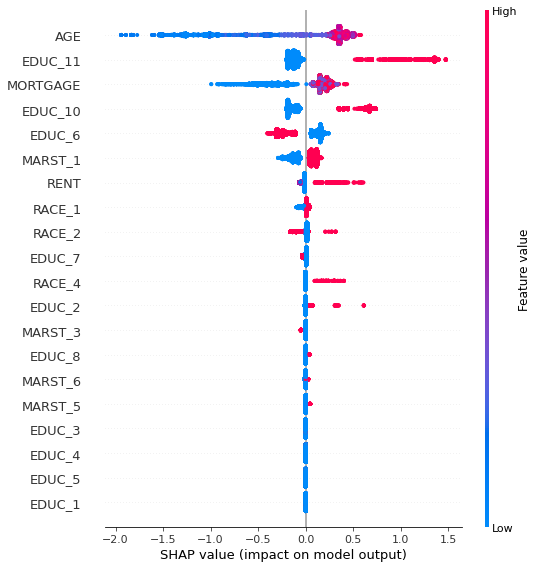

In [105]:
# Variable importance plot - how to read
# Age = normalized age, higher = higher chance of high income
# Educ 11 = 5+ years of college = higher chance of high income
# Mortgage = higher = higher chance of high income
shap.summary_plot(shap_values[1], X_train.astype("float"))

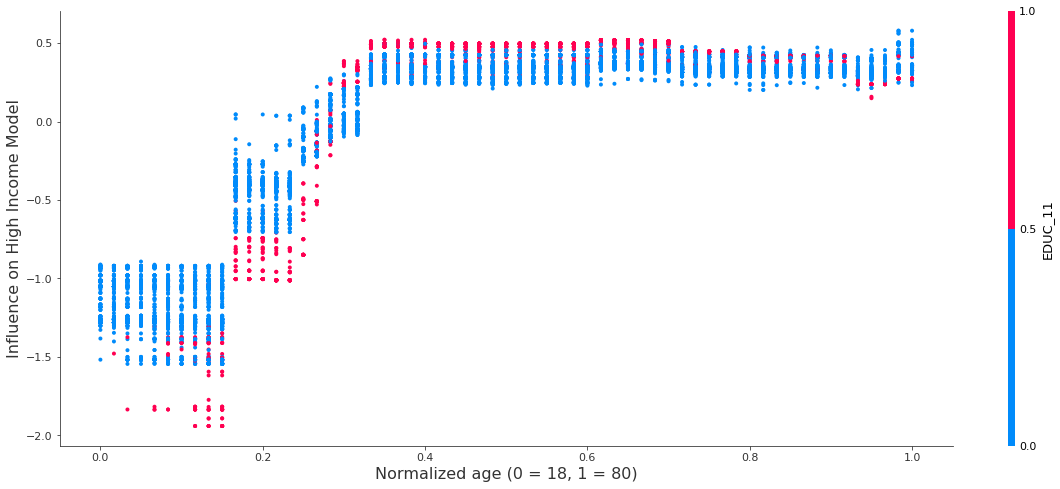

In [98]:
shap_2 = shap.dependence_plot("AGE", shap_values[1], X_train, show = False)
shap_2
fig = plt.gcf()
fig.set_figheight(8)
fig.set_figwidth(20)
ax = plt.gca()
ax.set_xlabel(r'Normalized age (0 = 18, 1 = 80)', fontsize=16)
ax.set_ylabel('Influence on High Income Model', fontsize=16)
plt.show()

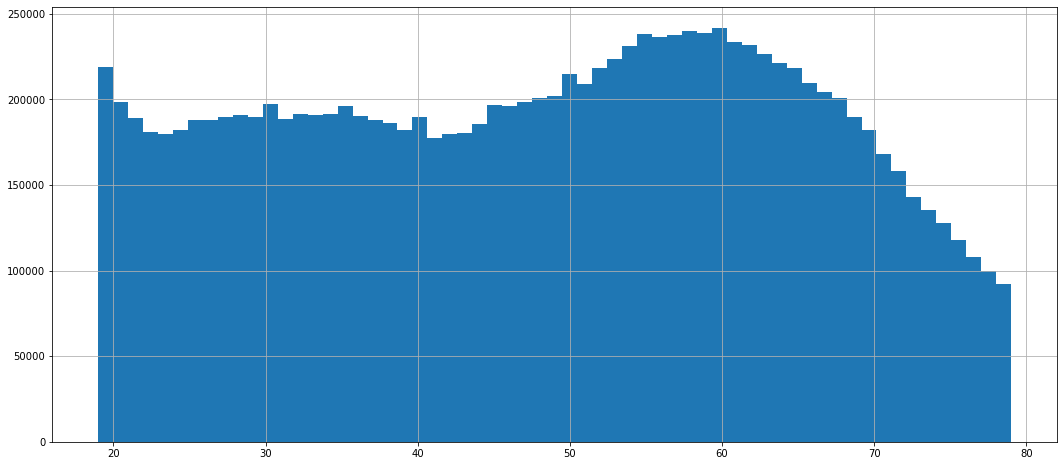

In [109]:
# Distribution of full population - model_input n = 5 MM / year, model_sample n = 20k
model_input.AGE.hist(bins = 61)
fig = plt.gcf()
fig.set_figheight(8)
fig.set_figwidth(18)